<a href="https://colab.research.google.com/github/skj092/Learning-Image-segnemation/blob/main/cars_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Download Data**

In [13]:
!touch kaggle.json

In [14]:
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [15]:
!kaggle competitions download -c carvana-image-masking-challenge

100% 24.4G/24.4G [21:09<00:00, 20.5MB/s]
100% 24.4G/24.4G [21:09<00:00, 20.6MB/s]


In [16]:
!unzip -q carvana-image-masking-challenge.zip

          No such file or directory


In [17]:
!unzip -q /content/train.zip

In [18]:
!unzip -q /content/train_masks.zip

**Importing library**

In [19]:
from fastai.vision.all import *
path = Path('.')
Path.BASE_PATH = path
images = get_image_files(path/'train')
masks = get_image_files(path/'train_masks')

In [20]:
len(images), len(masks)

(5088, 5088)

**Preparaing data for model**

In [21]:
def n_codes(fnames, is_partial=True):
    vals = set()
    if is_partial:
        random.shuffle(fnames)
        fnames = fnames[:10]
    for fname in fnames:
        msk = np.array(Image.open(fname).convert('L'))
    for val in np.unique(msk):
        if val not in vals:
            vals.add(val)
    vals = list(vals)
    p2c = dict()
    for i,val in enumerate(vals):
        p2c[i] = vals[i]
    return p2c

In [22]:
p2c = n_codes(masks)
p2c

{0: 0, 1: 255}

In [23]:
def get_msk(fn, p2c):
    fn = os.path.join('train_masks', fn.name.replace('.jpg', '_mask.gif'))
    msk = np.array(PILMask.create(fn))
    mx = np.max(msk)
    for i, val in enumerate(p2c):
        msk[msk==p2c[i]] = val
    return PILMask.create(msk)

In [24]:
get_y = lambda o: get_msk(o, p2c)

**Dataset and Dataloader**

In [25]:
codes = ['Background', 'Object']
binary = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes)),
    get_items=get_image_files,
    splitter=RandomSplitter(),
    get_y=get_y,
    item_tfms=Resize(224),
    batch_tfms=[Normalize.from_stats(*imagenet_stats)]
)

In [26]:
dls = binary.dataloaders(path/'train', bs=8)

In [27]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([8, 3, 224, 224]), torch.Size([8, 224, 224]))

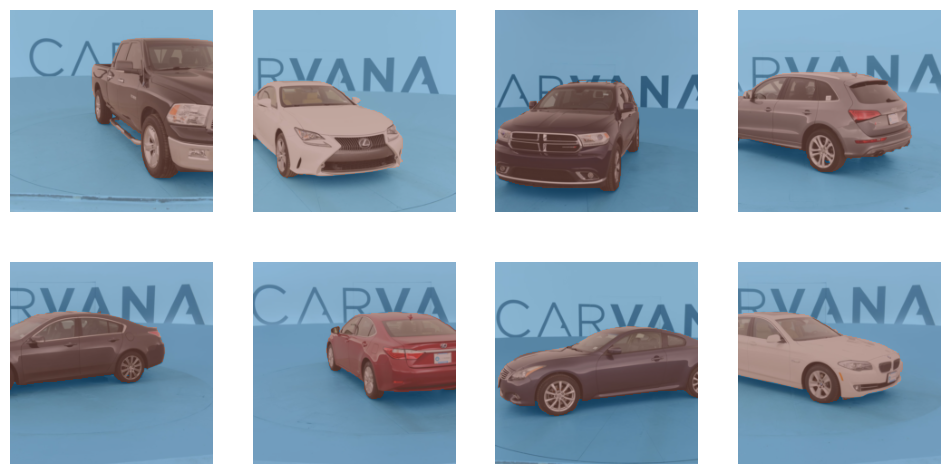

In [28]:
dls.show_batch()

**model**

In [29]:
learn = unet_learner(dls, resnet34)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 280MB/s]


In [30]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,time
0,0.017732,0.015652,04:33
1,0.009978,0.010338,04:20
2,0.008384,0.008998,04:23


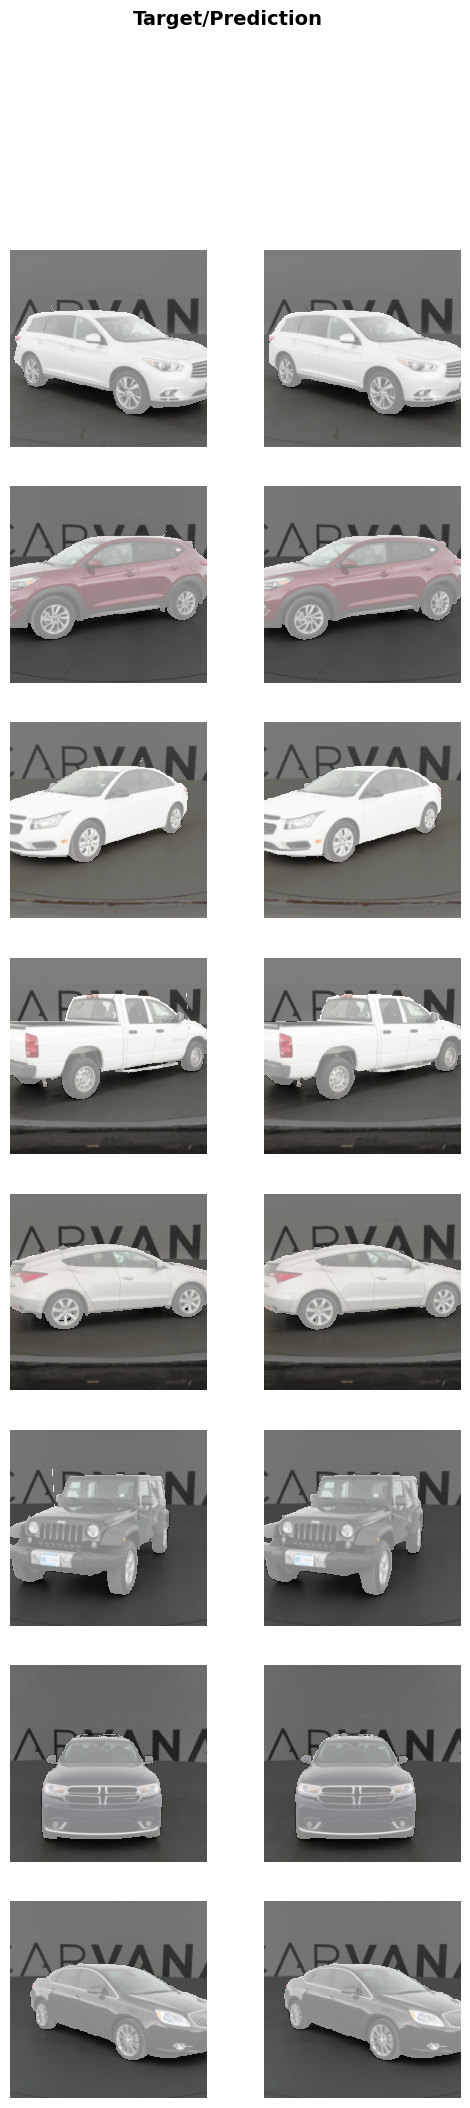

In [36]:
learn.show_results(cmap='gray', vmin=0, vmax=1)

In [ ]:
!unzip /content/test.zip

In [38]:
test_images = get_image_files('/content/test')
test_images

(#100064) [Path('/content/test/cc4766c37608_16.jpg'),Path('/content/test/e49772aad039_14.jpg'),Path('/content/test/cf5bedc9f40b_16.jpg'),Path('/content/test/4e13caca6c6d_13.jpg'),Path('/content/test/be0f52dbcf19_11.jpg'),Path('/content/test/8820e98a7528_02.jpg'),Path('/content/test/6e07b566f506_15.jpg'),Path('/content/test/620dfb778c14_13.jpg'),Path('/content/test/fdbe95520083_07.jpg'),Path('/content/test/ebc8b7b2766a_11.jpg')...]

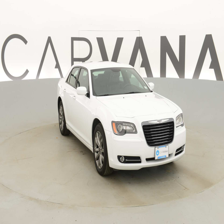

In [50]:
img_path = test_images[0]
Image.open(img_path).resize((224, 224))

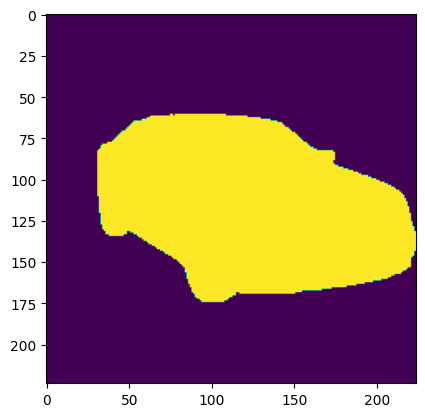

In [49]:

a, b, c = learn.predict(img_path)
plt.imshow(a)

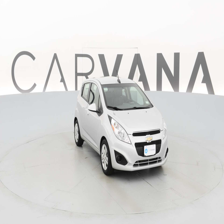

In [54]:
img_path = test_images[2]
Image.open(img_path).resize((224, 224))

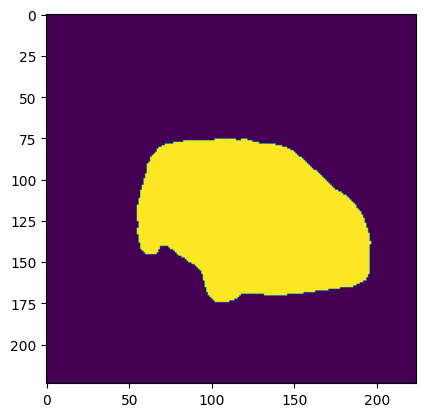

In [55]:
a, b, c = learn.predict(img_path)
plt.imshow(b)